In [2]:
import os
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
Étape 1 : Ajouter une couche d'attention graphique







class GraphAttentionLayer(layers.Layer):
    def __init__(self, hidden_units, dropout_rate=0.2, use_bias=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        # Poids pour la transformation linéaire.
        self.weight = self.add_weight(
            shape=(hidden_units, hidden_units), initializer="glorot_uniform", trainable=True
        )
        # Poids pour le calcul de l'attention.
        self.attention_weight = self.add_weight(
            shape=(2 * hidden_units, 1), initializer="glorot_uniform", trainable=True
        )
        self.dropout = layers.Dropout(dropout_rate)
        self.use_bias = use_bias
        if self.use_bias:
            self.bias = self.add_weight(shape=(hidden_units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        node_representations, edges, edge_weights = inputs
        # Transformation linéaire.
        transformed_nodes = tf.matmul(node_representations, self.weight)

        # Préparer les représentations pour l'attention.
        source_nodes = tf.gather(transformed_nodes, edges[0])  # Noeuds source
        target_nodes = tf.gather(transformed_nodes, edges[1])  # Noeuds voisins

        # Calcul des scores d'attention.
        concatenated_nodes = tf.concat([source_nodes, target_nodes], axis=-1)
        attention_scores = tf.nn.leaky_relu(
            tf.squeeze(tf.matmul(concatenated_nodes, self.attention_weight), axis=-1)
        )

        # Normalisation des scores avec softmax.
        attention_weights = tf.nn.softmax(attention_scores, axis=0)

        # Appliquer l'attention aux messages.
        weighted_messages = tf.expand_dims(attention_weights, axis=-1) * target_nodes
        aggregated_messages = tf.math.unsorted_segment_sum(
            weighted_messages, edges[0], num_segments=node_representations.shape[0]
        )

        # Ajout du biais si nécessaire.
        if self.use_bias:
            aggregated_messages += self.bias

        # Optionnel : Appliquer dropout et normalisation.
        return self.dropout(aggregated_messages)


Étape 2 : Intégrer GraphAttentionLayer dans GNNNodeClassifier
Remplacez les couches GraphConvLayer par des couches GraphAttentionLayer.

Modifiez le constructeur __init__ pour inclure les couches GAT :Étape 2 : Intégrer GraphAttentionLayer dans GNNNodeClassifier
Remplacez les couches GraphConvLayer par des couches GraphAttentionLayer.

Modifiez le constructeur __init__ pour inclure les couches GAT :



# Remplace GraphConvLayer par GraphAttentionLayer
self.gat1 = GraphAttentionLayer(
    hidden_units[0], dropout_rate, name="graph_attention1"
)
self.gat2 = GraphAttentionLayer(
    hidden_units[0], dropout_rate, name="graph_attention2"
)



Modifiez la méthode call pour utiliser GraphAttentionLayer :




# Appliquer la première couche d'attention graphique.
x1 = self.gat1((x, self.edges, self.edge_weights))
x = x1 + x  # Skip connection.

# Appliquer la deuxième couche d'attention graphique.
x2 = self.gat2((x, self.edges, self.edge_weights))
x = x2 + x  # Skip connection. 
2:35




<>:36: SyntaxWarning: invalid escape sequence '\S'
<>:36: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11180\3427434652.py:36: SyntaxWarning: invalid escape sequence '\S'
  """


Citations shape: (5429, 2)
Papers shape: (2708, 1435)
                         1925             404              1090  \
paper_id              1129015          1106849          1103016   
term_0                      0                0                0   
term_1                      0                0                0   
term_2                      0                0                1   
term_3                      0                0                0   
...                       ...              ...              ...   
term_1429                   0                0                0   
term_1430                   0                0                0   
term_1431                   0                0                0   
term_1432                   0                0                0   
subject    Genetic_Algorithms  Neural_Networks  Neural_Networks   

                            2078                935   
paper_id                 1109581             1153065  
term_0                         

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)   │ (None, 1433)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ffn_block1 (Sequential)       │ (None, 32)                │          52,804 │ input_features[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ffn_block2 (Sequential)       │ (None, 32)                │           2,368 │ ffn_block1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ skip_connection2 (Add)        │ (None, 32)                │               0 │ ffn_block1[0][0],          │
│                               │                           │                 │ ffn_block2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ffn_block3 (Sequential)       │ (None, 32)                │           2,368 │ skip_connection2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ skip_connection3 (Add)        │ (None, 32)                │               0 │ skip_connection2[0][0],    │
│                               │                           │                 │ ffn_block3[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ffn_block4 (Sequential)       │ (None, 32)                │           2,368 │ skip_connection3[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ skip_connection4 (Add)        │ (None, 32)                │               0 │ skip_connection3[0][0],    │
│                               │                           │                 │ ffn_block4[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ffn_block5 (Sequential)       │ (None, 32)                │           2,368 │ skip_connection4[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ skip_connection5 (Add)        │ (None, 32)                │               0 │ skip_connection4[0][0],    │
│                               │                           │                 │ ffn_block5[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 7)                 │             231 │ skip_connection5[0][0]     │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 62,507 (244.17 KB)

 Trainable params: 59,065 (230.72 KB)

 Non-trainable params: 3,442 (13.45 KB)

Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - acc: 0.1732 - loss: 3.6145 - val_acc: 0.1791 - val_loss: 1.9194
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2230 - loss: 2.3719 - val_acc: 0.1692 - val_loss: 1.9325
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2763 - loss: 1.9851 - val_acc: 0.1692 - val_loss: 1.8849
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.3045 - loss: 1.9185 - val_acc: 0.2338 - val_loss: 1.8321
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.3303 - loss: 1.8162 - val_acc: 0.3682 - val_loss: 1.7860
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.3747 - loss: 1.7088 - val_acc: 0.4627 - val_loss: 1.6537
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.4049 - loss: 1.6102 - val_acc: 0.4975 - val_loss: 1.5449
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.4427 - loss: 1.4930 - val_acc: 0.5373 - val_loss: 1.4620
Epoch 9/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - a

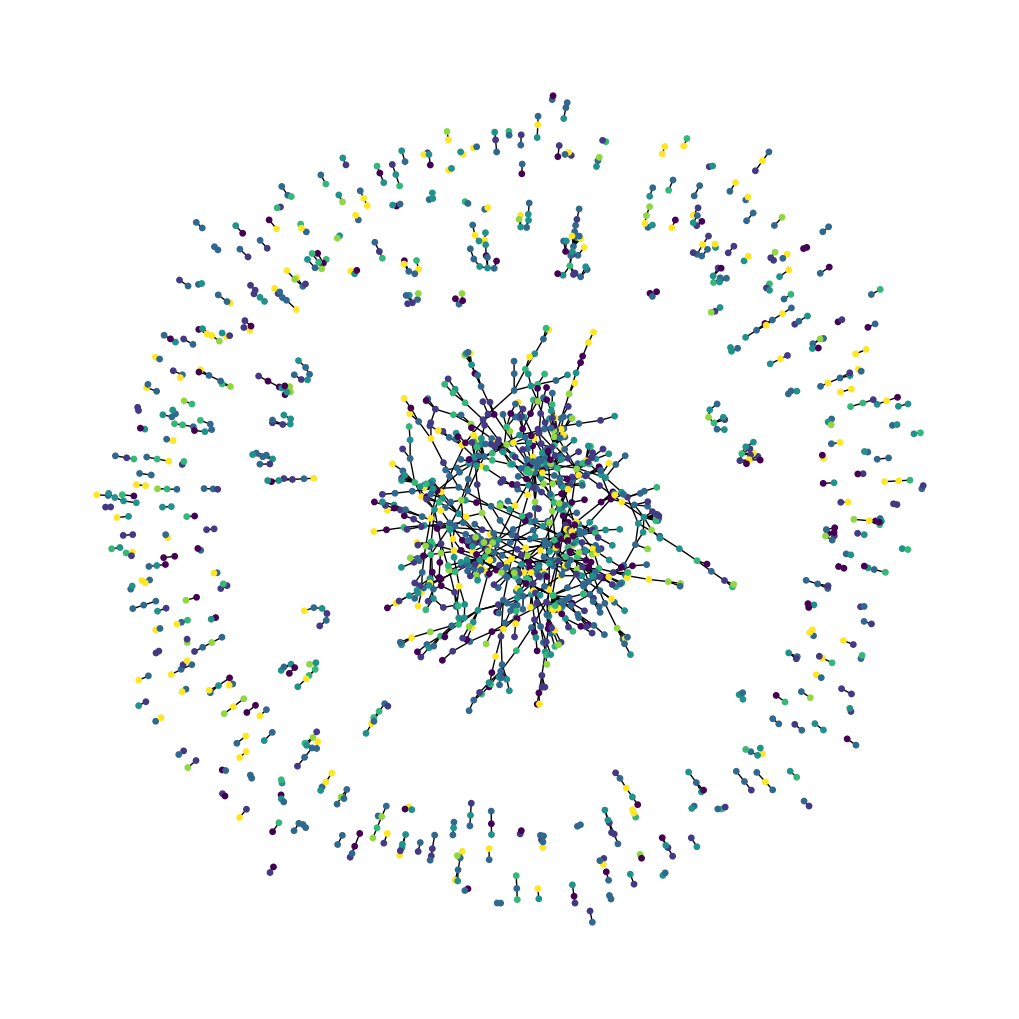

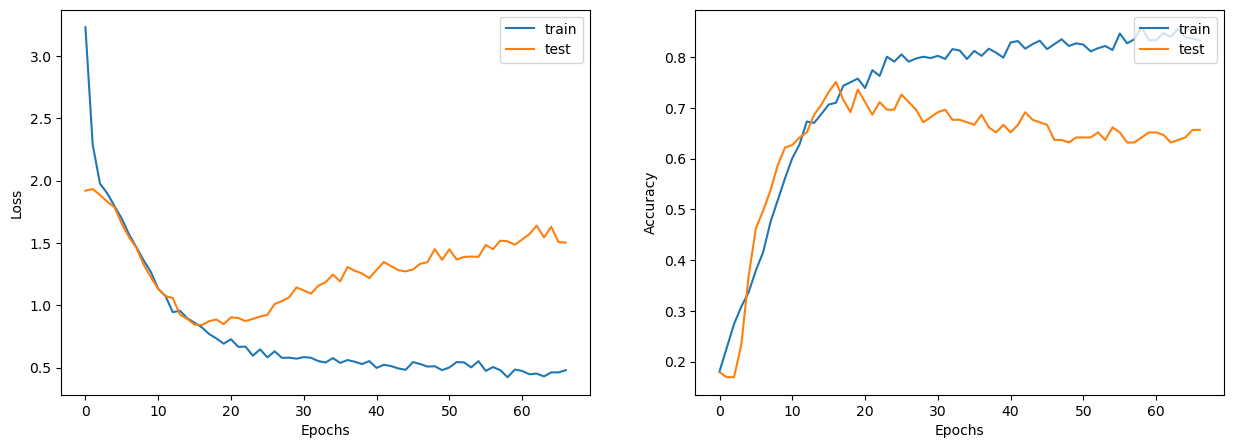

Test accuracy: 74.13%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Instance 1:
- Case_Based: 5.97%
- Genetic_Algorithms: 22.01%
- Neural_Networks: 29.54%
- Probabilistic_Methods: 8.59%
- Reinforcement_Learning: 11.44%
- Rule_Learning: 3.14%
- Theory: 19.32%
Instance 2:
- Case_Based: 0.66%
- Genetic_Algorithms: 95.11%
- Neural_Networks: 0.72%
- Probabilistic_Methods: 0.27%
- Reinforcement_Learning: 2.24%
- Rule_Learning: 0.1%
- Theory: 0.91%
Instance 3:
- Case_Based: 3.22%
- Genetic_Algorithms: 29.26%
- Neural_Networks: 39.98%
- Probabilistic_Methods: 7.13%
- Reinforcement_Learning: 12.17%
- Rule_Learning: 0.94%
- Theory: 7.3%
Instance 4:
- Case_Based: 4.04%
- Genetic_Algorithms: 5.95%
- Neural_Networks: 61.08%
- Probabilistic_Methods: 13.41%
- Reinforcement_Learning: 5.61%
- Rule_Learning: 4.54%
- Theory: 5.36%
Instance 5:
- Case_Based: 6.15%
- Genetic_Algorithms: 12.81%
- Neural_Networks: 15.92%
- Probabilistic_Methods: 15.63%
- Reinforcement_Learning: 7.07%
- Rule_Learning: 3.71%
- Theory: 38

Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_attention1                     │ ?                           │     0 (unbuilt) │
│ (GraphAttentionLayer)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_attention2                     │ ?                           │     0 (unbuilt) │
│ (GraphAttentionLayer)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,240 (8.75 KB)

 Trainable params: 2,240 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - acc: 0.2929 - loss: 1.7977 - val_acc: 0.5522 - val_loss: 1.2727
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.7134 - loss: 0.9079 - val_acc: 0.6368 - val_loss: 1.0776
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.8880 - loss: 0.3402 - val_acc: 0.6866 - val_loss: 1.2709
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9354 - loss: 0.1511 - val_acc: 0.6766 - val_loss: 1.3073
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9510 - loss: 0.1409 - val_acc: 0.6716 - val_loss: 1.7401
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9647 - loss: 0.1085 - val_acc: 0.6617 - val_loss: 2.5602
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9734 - loss: 0.0694 - val_acc: 0.6866 - val_loss: 1.7553
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9894 - loss: 0.0517 - val_acc: 0.7065 - val_loss: 1.6750
Epoch 9/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - a

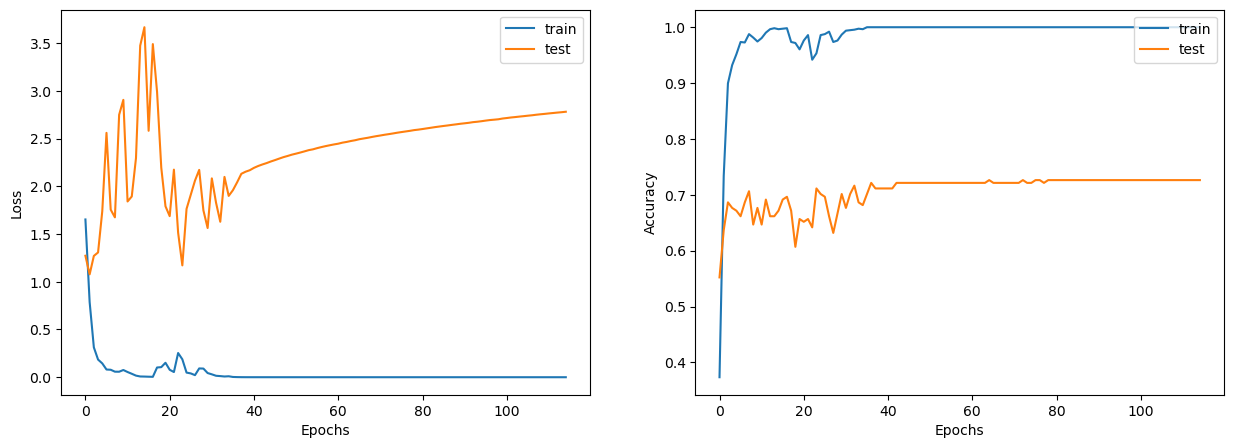

Test accuracy: 70.04%
Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Instance 1:
- Case_Based: 0.02%
- Genetic_Algorithms: 0.29%
- Neural_Networks: 98.03%
- Probabilistic_Methods: 0.03%
- Reinforcement_Learning: 0.01%
- Rule_Learning: 0.01%
- Theory: 1.62%
Instance 2:
- Case_Based: 0.0%
- Genetic_Algorithms: 100.0%
- Neural_Networks: 0.0%
- Probabilistic_Methods: 0.0%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.0%
Instance 3:
- Case_Based: 0.51%
- Genetic_Algorithms: 78.75%
- Neural_Networks: 4.11%
- Probabilistic_Methods: 0.05%
- Reinforcement_Learning: 0.05%
- Rule_Learning: 0.14%
- Theory: 16.4%
Instance 4:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.0%
- Neural_Networks: 100.0%
- Probabilistic_Methods: 0.0%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.0%
Instance 5:
- Case_Based: 0.08%
- Genetic_Algorithms: 0.02%
- 

'\nNotice that the probabilities of the expected subjects\n(to which several citations are added) are higher compared to the baseline model.\n'

In [3]:
"""
Title: Node Classification with Graph Neural Networks
Author: [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)
Date created: 2021/05/30
Last modified: 2021/05/30
Description: Implementing a graph neural network model for predicting the topic of a paper given its citations.
Accelerator: GPU
"""

"""
## Introduction

Many datasets in various machine learning (ML) applications have structural relationships
between their entities, which can be represented as graphs. Such application includes
social and communication networks analysis, traffic prediction, and fraud detection.
[Graph representation Learning](https://www.cs.mcgill.ca/~wlh/grl_book/)
aims to build and train models for graph datasets to be used for a variety of ML tasks.

This example demonstrate a simple implementation of a [Graph Neural Network](https://arxiv.org/pdf/1901.00596.pdf)
(GNN) model. The model is used for a node prediction task on the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA)
to predict the subject of a paper given its words and citations network.

Note that, **we implement a Graph Convolution Layer from scratch** to provide better
understanding of how they work. However, there is a number of specialized TensorFlow-based
libraries that provide rich GNN APIs, such as [Spectral](https://graphneural.network/),
[StellarGraph](https://stellargraph.readthedocs.io/en/stable/README.html), and
[GraphNets](https://github.com/deepmind/graph_nets).
"""

"""
## Setup
"""



"""
## Prepare the Dataset
cora_env1\Scripts\activate

The Cora dataset consists of 2,708 scientific papers classified into one of seven classes.
The citation network consists of 5,429 links. Each paper has a binary word vector of size
1,433, indicating the presence of a corresponding word.

### Download the dataset

The dataset has two tap-separated files: `cora.cites` and `cora.content`.

1. The `cora.cites` includes the citation records with two columns:
`cited_paper_id` (target) and `citing_paper_id` (source).
2. The `cora.content` includes the paper content records with 1,435 columns:
`paper_id`, `subject`, and 1,433 binary features.

Let's download the dataset.
"""

zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")
"""
### Process and visualize the dataset

Then we load the citations data into a Pandas DataFrame.
"""

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

"""
Now we display a sample of the `citations` DataFrame.
The `target` column includes the paper ids cited by the paper ids in the `source` column.
"""

citations.sample(frac=1).head()

"""
Now let's load the papers data into a Pandas DataFrame.
"""

column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=column_names,
)
print("Papers shape:", papers.shape)

"""
Now we display a sample of the `papers` DataFrame. The DataFrame includes the `paper_id`
and the `subject` columns, as well as 1,433 binary column representing whether a term exists
in the paper or not.
"""

print(papers.sample(5).T)

"""
Let's display the count of the papers in each subject.
"""

print(papers.subject.value_counts())

"""
We convert the paper ids and the subjects into zero-based indices.
"""

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

"""
Now let's visualize the citation graph. Each node in the graph represents a paper,
and the color of the node corresponds to its subject. Note that we only show a sample of
the papers in the dataset.
"""

plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


"""
### Split the dataset into stratified train and test sets
"""

train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

"""
## Implement Train and Evaluate Experiment
"""

hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 500
batch_size = 64

""" 
This function compiles and trains an input model using the given training data.
"""


def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


"""
This function displays the loss and accuracy curves of the model during training.
"""


def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


"""
## Implement Feedforward Network (FFN) Module

We will use this module in the baseline and the GNN models.
"""


def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


"""
## Build a Baseline Neural Network Model

### Prepare the data for the baseline model
"""

feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

"""
### Implement a baseline classifier

We add five FFN blocks with skip connections, so that we generate a baseline model with
roughly the same number of parameters as the GNN models to be built later.
"""


def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

"""
### Train the baseline classifier
"""

history = run_experiment(baseline_model, x_train, y_train)

"""
Let's plot the learning curves.
"""

display_learning_curves(history)

"""
Now we evaluate the baseline model on the test data split.
"""

_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

"""
### Examine the baseline model predictions

Let's create new data instances by randomly generating binary word vectors with respect to
the word presence probabilities.
"""


def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


"""
Now we show the baseline model predictions given these randomly generated instances.
"""

new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

"""
## Build a Graph Neural Network Model

### Prepare the data for the graph model

Preparing and loading the graphs data into the model for training is the most challenging
part in GNN models, which is addressed in different ways by the specialised libraries.
In this example, we show a simple approach for preparing and using graph data that is suitable
if your dataset consists of a single graph that fits entirely in memory.

The graph data is represented by the `graph_info` tuple, which consists of the following
three elements:

1. `node_features`: This is a `[num_nodes, num_features]` NumPy array that includes the
node features. In this dataset, the nodes are the papers, and the `node_features` are the
word-presence binary vectors of each paper.
2. `edges`:  This is `[num_edges, num_edges]` NumPy array representing a sparse
[adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#:~:text=In%20graph%20theory%20and%20computer,with%20zeros%20on%20its%20diagonal.)
of the links between the nodes. In this example, the links are the citations between the papers.
3. `edge_weights` (optional): This is a `[num_edges]` NumPy array that includes the edge weights, which *quantify*
the relationships between nodes in the graph. In this example, there are no weights for the paper citations.
"""

# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

"""
### Implement a graph convolution layer

We implement a graph convolution module as a [Keras Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer?version=nightly).
Our `GraphConvLayer` performs the following steps:

1. **Prepare**: The input node representations are processed using a FFN to produce a *message*. You can simplify
the processing by only applying linear transformation to the representations.
2. **Aggregate**: The messages of the neighbours of each node are aggregated with
respect to the `edge_weights` using a *permutation invariant* pooling operation, such as *sum*, *mean*, and *max*,
to prepare a single aggregated message for each node. See, for example, [tf.math.unsorted_segment_sum](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum)
APIs used to aggregate neighbour messages.
3. **Update**: The `node_repesentations` and `aggregated_messages`—both of shape `[num_nodes, representation_dim]`—
are combined and processed to produce the new state of the node representations (node embeddings).
If `combination_type` is `gru`, the `node_repesentations` and `aggregated_messages` are stacked to create a sequence,
then processed by a GRU layer. Otherwise, the `node_repesentations` and `aggregated_messages` are added
or concatenated, then processed using a FFN.


The technique implemented use ideas from [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907),
[GraphSage](https://arxiv.org/abs/1706.02216), [Graph Isomorphism Network](https://arxiv.org/abs/1810.00826),
[Simple Graph Networks](https://arxiv.org/abs/1902.07153), and
[Gated Graph Sequence Neural Networks](https://arxiv.org/abs/1511.05493).
Two other key techniques that are not covered are [Graph Attention Networks](https://arxiv.org/abs/1710.10903)
and [Message Passing Neural Networks](https://arxiv.org/abs/1704.01212).
"""


def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
        x = layers.GRU(
            units=units,
            activation="tanh",
            recurrent_activation="sigmoid",
            return_sequences=True,
            dropout=dropout_rate,
            return_state=False,
            recurrent_dropout=dropout_rate,
        )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphAttentionLayer(layers.Layer):
    def __init__(self, hidden_units, dropout_rate=0.2, use_bias=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        # Poids pour la transformation linéaire.
        self.weight = self.add_weight(
            shape=(hidden_units, hidden_units), initializer="glorot_uniform", trainable=True
        )
        # Poids pour le calcul de l'attention.
        self.attention_weight = self.add_weight(
            shape=(2 * hidden_units, 1), initializer="glorot_uniform", trainable=True
        )
        self.dropout = layers.Dropout(dropout_rate)
        self.use_bias = use_bias
        if self.use_bias:
            self.bias = self.add_weight(shape=(hidden_units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        node_representations, edges, edge_weights = inputs
        # Transformation linéaire.
        transformed_nodes = tf.matmul(node_representations, self.weight)

        # Préparer les représentations pour l'attention.
        source_nodes = tf.gather(transformed_nodes, edges[0])  # Noeuds source
        target_nodes = tf.gather(transformed_nodes, edges[1])  # Noeuds voisins

        # Calcul des scores d'attention.
        concatenated_nodes = tf.concat([source_nodes, target_nodes], axis=-1)
        attention_scores = tf.nn.leaky_relu(
            tf.squeeze(tf.matmul(concatenated_nodes, self.attention_weight), axis=-1)
        )

        # Normalisation des scores avec softmax.
        attention_weights = tf.nn.softmax(attention_scores, axis=0)

        # Appliquer l'attention aux messages.
        weighted_messages = tf.expand_dims(attention_weights, axis=-1) * target_nodes
        aggregated_messages = tf.math.unsorted_segment_sum(
            weighted_messages, edges[0], num_segments=node_representations.shape[0]
        )

        # Ajout du biais si nécessaire.
        if self.use_bias:
            aggregated_messages += self.bias

        # Optionnel : Appliquer dropout et normalisation.
        return self.dropout(aggregated_messages)

"""
### Implement a graph neural network node classifier

The GNN classification model follows the [Design Space for Graph Neural Networks](https://arxiv.org/abs/2011.08843) approach,
as follows:

1. Apply preprocessing using FFN to the node features to generate initial node representations.
2. Apply one or more graph convolutional layer, with skip connections,  to the node representation
to produce node embeddings.
3. Apply post-processing using FFN to the node embeddings to generate  the final node embeddings.
4. Feed the node embeddings in a Softmax layer to predict the node class.

Each graph convolutional layer added captures information from a further level of neighbours.
However, adding many graph convolutional layer can cause oversmoothing, where the model
produces similar embeddings for all the nodes.

Note that the `graph_info` passed to the constructor of the Keras model, and used as a *property*
of the Keras model object, rather than input data for training or prediction.
The model will accept a **batch** of `node_indices`, which are used to lookup the
node features and neighbours from the `graph_info`.
"""


class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.gat1 = GraphAttentionLayer(
        hidden_units[0], dropout_rate, name="graph_attention1"
        )
        self.gat2 = GraphAttentionLayer(
            hidden_units[0], dropout_rate, name="graph_attention2"
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        # Appliquer la première couche d'attention graphique.
        x1 = self.gat1((x, self.edges, self.edge_weights))
        x = x1 + x  # Skip connection.
        
        # Appliquer la deuxième couche d'attention graphique.
        x2 = self.gat2((x, self.edges, self.edge_weights))
        x = x2 + x  # Skip connection. 
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


"""
Let's test instantiating and calling the GNN model.
Notice that if you provide `N` node indices, the output will be a tensor of shape `[N, num_classes]`,
regardless of the size of the graph.
"""

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)


gnn_model.summary()

"""
### Train the GNN model

Note that we use the standard *supervised* cross-entropy loss to train the model.
However, we can add another *self-supervised* loss term for the generated node embeddings
that makes sure that neighbouring nodes in graph have similar representations, while faraway
nodes have dissimilar representations.
"""

x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

"""
Let's plot the learning curves
"""

display_learning_curves(history)

"""
Now we evaluate the GNN model on the test data split.
The results may vary depending on the training sample, however the GNN model always outperforms
the baseline model in terms of the test accuracy.
"""

x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

"""
### Examine the GNN model predictions

Let's add the new instances as nodes to the `node_features`, and generate links
(citations) to existing nodes.
"""

# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

"""
Now let's update the `node_features` and the `edges` in the GNN model.
"""

print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

"""
Notice that the probabilities of the expected subjects
(to which several citations are added) are higher compared to the baseline model.
"""